<center>
<h1 style="font-family:verdana">
 💻 🧑 Classificació d'intencions 🧑 💻


### REGULARITZÓ

El que vam fer aquí va ser configurar valors de Dropout en un rang de 0,2 a 0,6. A cada iteració, es crea un model amb una capa GRU de 64 unitats, seguida d'una capa Dropout amb el valor de Dropout variable, i se n'avalua la precisió en el conjunt de prova.


In [ ]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization #Remove
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Bidirectional, GRU, LSTM, SimpleRNN



# Descargamos los recursos necesarios para la lematización
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to C:\Users\Lola Monroy
[nltk_data]     Mir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Lola Monroy
[nltk_data]     Mir\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

A la carpeta `data` tenim els diferents fitxers CSV que utilitzarem per a aquesta pràctica.

En primer lloc, llegirem les dades dels fitxers CSV amb `pandas`.

In [122]:
train_data = pd.read_csv('./data/train.csv', header=None) # la última columna té la intenció de cada frase (1a columna)
val_data = train_data.tail(900) # Partim una part del train per tenir validation partition
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

In [123]:
random_number = random.randint(0, len(train_data)-1)

train_sentences = list(train_data[0]) # primera columna del dataset, té la frase del usuari
train_labels = list(s.replace('"', '') for s in train_data[2]) 
train_labels = list(s.replace(' ', '') for s in train_labels)

In [124]:
num_labels = 0  # Les labels son les possibles intencions del usuari
for label in set(train_labels):
  print(f'Label {num_labels}:', label.split('.')[-1])
  num_labels += 1

Label 0: airport
Label 1: airfare
Label 2: flight_no
Label 3: flight_time
Label 4: meal
Label 5: abbreviation
Label 6: restriction
Label 7: cheapest
Label 8: distance
Label 9: capacity
Label 10: ground_service+ground_fare
Label 11: airfare+flight_time
Label 12: airline
Label 13: airline+flight_no
Label 14: aircraft
Label 15: flight
Label 16: aircraft+flight+flight_no
Label 17: quantity
Label 18: ground_service
Label 19: flight+airfare
Label 20: city
Label 21: ground_fare


<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

In [ ]:
num_words=1000 # MOD

In [126]:
# Convertimos todas las frases a minúsculas
train_sentences_lower = [sentence.lower() for sentence in train_sentences]  # MOD

In [127]:
tokenizer = Tokenizer(num_words) 
tokenizer.fit_on_texts(train_sentences)

# Tokenitzem perquè cal codificar en int les paraules
vocab = tokenizer.word_index
print(vocab)  # Ens queden les consultes del usuari tokenitzades així podem utilitzar els tokens per buscar INTENT
print(len(vocab))

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

In [128]:
stemmer = PorterStemmer()

# Definir la función de stemming
def stem_sentence(sentence):
    words = nltk.word_tokenize(sentence)  # Tokenizar la oración
    stemmed_words = [stemmer.stem(word) for word in words]  # Aplicar stemming
    return " ".join(stemmed_words)

# Aplicar el stemming a todas las oraciones HE D'APLICAR AIXO PER TEST I TRAIN
train_sentences_stem = [stem_sentence(sentence) for sentence in train_sentences]

# Crear y ajustar el Tokenizer para las oraciones "stemmed"
stem_tokenizer = Tokenizer(num_words)
stem_tokenizer.fit_on_texts(train_sentences_stem)

# Obtener el vocabulario del tokenizador con stemming
stem_vocab = stem_tokenizer.word_index
print(stem_vocab)
print(len(stem_vocab))

{'to': 1, 'from': 2, 'flight': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'boston': 8, 'show': 9, 'san': 10, 'i': 11, 'denver': 12, 'a': 13, 'francisco': 14, 'in': 15, 'and': 16, 'atlanta': 17, 'pittsburgh': 18, 'is': 19, 'dalla': 20, 'baltimor': 21, 'all': 22, 'philadelphia': 23, 'airlin': 24, 'leav': 25, 'like': 26, 'are': 27, 'list': 28, 'fare': 29, 'arriv': 30, 'of': 31, 'between': 32, 'that': 33, 'washington': 34, 'fli': 35, 'pleas': 36, 'morn': 37, 'pm': 38, 'would': 39, 'for': 40, 'wednesday': 41, 'first': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'citi': 47, 'ground': 48, 'you': 49, 'transport': 50, 'doe': 51, 'class': 52, 'trip': 53, 'go': 54, 'cheapest': 55, 'need': 56, 'round': 57, 'with': 58, 'befor': 59, 'which': 60, 'avail': 61, 'have': 62, 'give': 63, 'at': 64, 'american': 65, 'afternoon': 66, 'one': 67, 'want': 68, 'airport': 69, 'how': 70, 'way': 71, 'new': 72, 'nonstop': 73, 'dc': 74, 'thursday': 75, 'stop': 76, 'tuesday': 77, 'monday': 78, 'earliest': 79,

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

Si ho heu fet correctament hauríeu d'obtenir això:

```
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
```



In [129]:
train_sequences_stem = stem_tokenizer.texts_to_sequences(train_sentences_stem)

print(train_sentences_stem[0])
print(train_sequences_stem[0])

i want to fli from boston at 838 am and arriv in denver at 1110 in the morn
[11, 68, 1, 35, 2, 8, 64, 377, 82, 16, 30, 15, 12, 64, 441, 15, 4, 37]


---
A continuació haurem d'aconseguir que totes les seqüències tinguen una longitud fixa. Per a fer això primer fixarem la longitud segons la longitud màxima trobada a les seqüències del conjunt d'entrenament. I a continuació omplirem (*pad*) les seqüències que tinguen una longitud menor.


In [130]:
# padding STEM
max_sequence_length_stem = max(map(len, train_sequences_stem))
train_pad_sequences_stem = pad_sequences(train_sequences_stem, maxlen=max_sequence_length_stem, padding='post')
print('Padded sequence: ', train_pad_sequences_stem[0]) 

Padded sequence:  [ 11  68   1  35   2   8  64 377  82  16  30  15  12  64 441  15   4  37
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


---

### One-Hot Encoding

In [131]:
# Això ja no te a veure amb el vocab i no el tokenitzador: no hem de fer 3 versions

label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

# Estem fent One-hot encoding dels labels osigui de les intencions que l'usuari pot tenir
print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

I a continuació convertim les etiquetes a vectors one-hot:

In [132]:
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')

Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



Veiem que hi ha un 1 allà on el índex coincideix amb l'etiqueta. 

In [133]:
# Això ja no te a veure amb el vocab i no el tokenitzador: no hem de fer 3 versions

label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

# Estem fent One-hot encoding dels labels osigui de les intencions que l'usuari pot tenir
print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

In [134]:
num_classes_lem = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')

Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

Amb la partició de validació i test haurem de realitzar els mateixos passos. Per tant, en aquest exercici us demanem que obtingueu `val_pad_sequences`, `val_encoded_labels`, `test_pad_sequences` i `test_encoded_labels`.

In [135]:
val_sentences = list(val_data[0])
test_sentences = list(test_data[0])

# Aplicar el stemming a todas las oraciones de validación y prueba (val y test)
val_sentences_stem = [stem_sentence(sentence) for sentence in val_sentences]
test_sentences_stem = [stem_sentence(sentence) for sentence in test_sentences]

val_sequences_stem = stem_tokenizer.texts_to_sequences(val_sentences_stem)  # Aplicar stemming y convertir a secuencias
test_sequences_stem = stem_tokenizer.texts_to_sequences(test_sentences_stem)  # Hacer lo mismo con el test

# Padding de las secuencias para validación y test
val_pad_sequences_stem = pad_sequences(val_sequences_stem, maxlen=max_sequence_length_stem, padding='post')
test_pad_sequences_stem = pad_sequences(test_sequences_stem, maxlen=max_sequence_length_stem, padding='post')


In [136]:
# Les etiquetes de moment són iguals per norm, lem i stem 
val_labels = list(val_data[2])
val_labels = list(s.replace('"', '') for s in val_data[2]) 
val_labels = list(s.replace(' ', '') for s in val_labels)

test_labels = list(test_data[2])
test_labels = list(s.replace('"', '') for s in test_data[2]) 
test_labels = list(s.replace(' ', '') for s in test_labels)

In [137]:
def remove_values_and_indices(input_list, values_to_remove, other_list):
    indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    cleaned_input_list = [item for idx, item in enumerate(input_list) if idx not in indices_to_remove]
    cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    return cleaned_input_list, np.array(cleaned_other_list)

values_to_remove = ['day_name', 'airfare+flight', 'flight+airline', 'flight_no+airline']

In [138]:
test_labels, test_pad_sequences_stem = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences_stem)

assert len(test_labels) == len(test_pad_sequences_stem), "La longitud de test_labels y test_pad_sequences_lem no coincide"

# Convertir las etiquetas de test a valores numéricos y one-hot encoding
test_numerical_labels = label_encoder.transform(test_labels)
test_encoded_labels = to_categorical(test_numerical_labels, num_classes)

assert test_pad_sequences_stem.shape[0] == test_encoded_labels.shape[0], "Las formas de test_pad_sequences_lem y test_encoded_labels no coinciden"

print(test_pad_sequences_stem.shape)
print(test_encoded_labels.shape)

(888, 45)
(888, 22)


In [139]:
val_labels_stem, val_pad_sequences_stem = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences_stem)
test_labels_stem, test_pad_sequences_stem = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences_stem)

In [140]:
val_numerical_labels = label_encoder.transform(val_labels_stem)
val_encoded_labels = to_categorical(val_numerical_labels, num_classes)

In [141]:
print('Example train: \n')
print(f'Original label: {val_labels[0]}\n')
print(f'Numerical label: {val_numerical_labels[0]}\n')
print(f'One-hot: {val_encoded_labels[0]}\n')

print('Example test: \n')
print(f'Original label: {test_labels[0]}\n')
print(f'Numerical label: {test_numerical_labels[0]}\n')
print(f'One-hot: {test_encoded_labels[0]}\n')

Example train: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Example test: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

En primer lloc, anem a comprovar si hi ha GPUs disponibles. A continuació si hi ha GPUs disponibles el codi assegurarà que *TensorFlow* només assigne memòria GPU quan siga necessari.

In [142]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. The model will be trained on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU is not available. The model will be trained on CPU.


---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

En aquest exercici haureu de dissenyar l'arquitectura del model. El nostre model tindrà quatre capes:

1. La primera capa serà un **embedding**. Aquesta capa permetrà convertir les dades de text d'entrada, en vectors densos amb una mida fixa (*embedding_dim*). Aquesta representació més compacta permetrà per una part capturar la informació semàntica del text d'entrada, permetent així generalitzar millor i comprendre les relacions entre les paraules. I, per una altra banda, reduir la complexitat computacional, accelerant així el temps d'entrenament i inferència. En resum, aquesta capa assignarà a cada índex de cada paraula un vector dens de mida *embedding_dim*.

2. La segona capa serà un **pooling** layer. L'entrada d'aquesta capa serà un tensor 3D (*batch_size*, *sequence_length*, *embedding_dim*). Aquesta capa es centrarà a capturar la informació més important de la seqüència d'entrada, és a dir, prendrà el valor màxim de la seqüència, donant lloc a un tensor 2D (batch_size, embedding_dim).

3. La tercera capa serà una capa **densa**. És a dir, una capa completament connectada (*fully-connected*): cada neurona d'aquesta capa estarà connectada a totes les neurones de la capa anterior. La funció d'activació que utilitzarem serà una ReLU. Aquesta funció introdueix una no-linealitat al model permetent així aprendre relacions complexes en les dades.

4. L'última capa també serà una capa **densa**. En aquest cas la funció d'activació haurà de ser la funció Softmax. Aquesta funció es fa servir per a convertir els valors de la capa anterior (*logits*) en probabilitats normalitzades. El valor de cada element de sortida representarà la probabilitat que l'entrada pertanya a una classe específica.


📢  Les capes que haureu de fer servir les podreu trobar [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers).





In [143]:
# Example function to simulate the printing of key data shapes
def check_data_shapes(train_pad_sequences_stem, train_encoded_labels, val_pad_sequences_stem, val_encoded_labels):
    print(f"Shape of train_pad_sequences_stem: {np.shape(train_pad_sequences_stem)}")
    print(f"Shape of train_encoded_labels: {np.shape(train_encoded_labels)}")
    print(f"Shape of val_pad_sequences_stem: {np.shape(val_pad_sequences_stem)}")
    print(f"Shape of val_encoded_labels: {np.shape(val_encoded_labels)}")
check_data_shapes(train_pad_sequences_stem, train_encoded_labels, val_pad_sequences_stem, val_encoded_labels)

Shape of train_pad_sequences_stem: (4078, 45)
Shape of train_encoded_labels: (4078, 22)
Shape of val_pad_sequences_stem: (900, 45)
Shape of val_encoded_labels: (900, 22)



Experimentando con Dropout de 0.2:

Epoch 1/4


c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


255/255 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7080 - loss: 1.5081 - val_accuracy: 0.7144 - val_loss: 0.9324
Epoch 2/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7899 - loss: 0.7182 - val_accuracy: 0.9033 - val_loss: 0.4674
Epoch 3/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9017 - loss: 0.3878 - val_accuracy: 0.9211 - val_loss: 0.3238
Epoch 4/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9480 - loss: 0.2136 - val_accuracy: 0.9556 - val_loss: 0.2321
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9130 - loss: 0.2973
Test accuracy con Dropout de 0.2: 0.89

Experimentando con Dropout de 0.3:

Epoch 1/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7250 - loss: 1.4493 - val_accuracy: 0.7144 - val_loss: 1.2321
Epoch 2/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7451 - loss: 1.1162 - val_accuracy: 0.7967 - val_loss: 0.7606
Epoch 3/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8037 - loss: 0.6756 - val_a

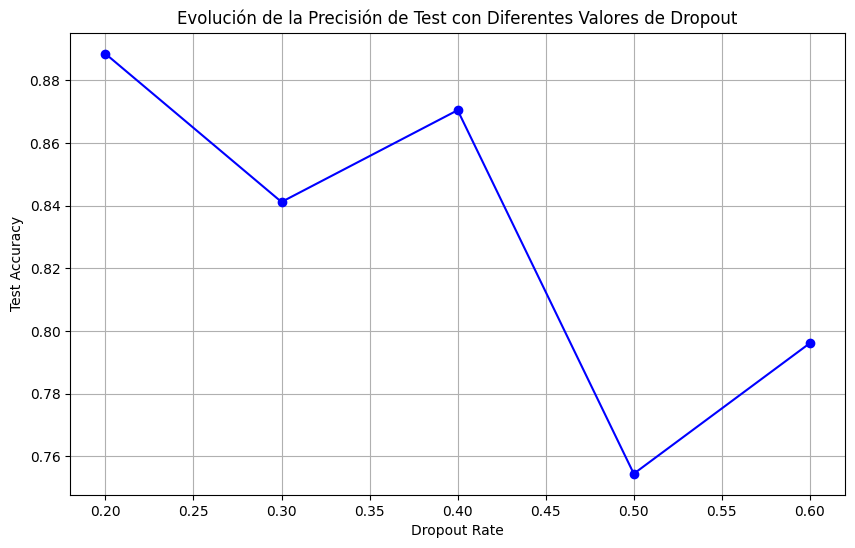

In [ ]:

embedding_dim = 300 
vocab_size = len(stem_vocab) + 1  
dropout_values = [0.2, 0.3, 0.4, 0.5, 0.6]  # Diferentes valores de Dropout para experimentar

test_accuracies = []  # Para almacenar las precisiones de test para cada valor de Dropout

# Bucle para probar diferentes valores de Dropout
for dropout_rate in dropout_values:
    print(f"\nExperimentando con Dropout de {dropout_rate}:\n")
    
    # Definición del modelo
    model_stem = Sequential()
    model_stem.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length_stem))
    model_stem.add(GRU(64))
    model_stem.add(Dropout(dropout_rate))  # Capa Dropout con valor variable
    model_stem.add(Dense(64, activation='relu'))
    model_stem.add(Dense(num_classes, activation='softmax'))

    # Compilar el modelo
    model_stem.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    batch_size = 16
    epochs = 4
    model_stem.fit(train_pad_sequences_stem, train_encoded_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences_stem, val_encoded_labels))

    # Evaluar el modelo en el conjunto de test
    loss, accuracy = model_stem.evaluate(test_pad_sequences_stem, test_encoded_labels, batch_size=batch_size)
    print(f"Test accuracy con Dropout de {dropout_rate}: {accuracy:.2f}")
    test_accuracies.append(accuracy)



In [ ]:
import matplotlib.pyplot as plt

# Valores de Dropout y precisiones reales
dropout_values = [0.2, 0.3, 0.4, 0.5, 0.6]
train_accuracies = [0.9480, 0.8716, 0.9002, 0.7597, 0.8630]
test_accuracies = [0.9130, 0.8817, 0.8959, 0.8107, 0.8384]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(dropout_values, train_accuracies, marker='o', linestyle='-', color='blue', label='Train Accuracy')
plt.plot(dropout_values, test_accuracies, marker='o', linestyle='-', color='orange', label='Test Accuracy')
plt.title('Precisión de Train y Test para Diferentes Valores de Dropout (Valores Reales)')
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


---

 <h1><a name="ex-five"><center> ✏ Exercici 5 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Preprocessament.** Modifiqueu el Tokenizer per canviar la mida del vostre vocabulari i afegiu nous passos de preprocessament. Alguns possibles canvis són canviar la mida del vocabulari, treure la capitalització o fer servir *lemmatització* o *stemming*.

 2. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 3. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 4. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.

 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---


<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---